In [1]:
import pandas as pd

from fluxo.dados import Dados
from fluxo.carga_dados import CargaDados
from fluxo.limpeza_dados import LimpezaDados
from fluxo.preprocessamento import Preprocessamento
from fluxo.extracao_caracteristicas import ExtracaoCaracteristicas
from fluxo.treinamento import Treinamento
from fluxo.classificador import Classificador
from fluxo.persistencia_modelo import PersistenciaModelo

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import joblib

In [2]:
pd.set_option('max_colwidth', 180)

In [3]:
# Definição do tipo de ato
# Valores válidos: 'ADE', 'SC' ou 'Port.'
# O valor desta variável influencia todo o comportamento deste notebook
tipo_ato = 'ADE'

## Carga de Dados

In [4]:
dados = Dados()

In [5]:
cg = CargaDados()
cg.executar(dados)

17:38:45 - Carregando dados de segmentos...
17:38:46 - 12013 registros carregados.


## Limpeza de Dados

In [6]:
lp = LimpezaDados(dados)
lp.executar(dados, tipo_ato, reclassificar_nao_identificados=True)

17:38:46 - (Re)Carregando segmentos originais...
17:38:46 - Removendo segmentos nulos...
17:38:46 - 15 segmentos nulos excluídos.
17:38:46 - Restaram 11998 segmentos não nulos.
17:38:46 - Removendo todos os segmentos do tipo Anexo...
17:38:46 - 302 segmentos do tipo Anexo excluídos.
17:38:46 - Determinando tipos de segmento (labels) para atos do tipo ADE...
17:38:46 - Tipos de segmento para atos ADE: ['Ementa', 'Fecho', 'Não Identificado']
17:38:46 - Excluindo segmentos dos atos que não são ADE...
17:38:46 - 5558 segmentos de atos não ADE excluídos.
17:38:46 - Restaram 6138 segmentos de atos ADE.
17:38:46 - Removendo segmentos não representativos para o tipo ADE...
17:38:46 - 105 segmentos não representativos excluídos.
17:38:46 - Restaram 6033 segmentos representativos.
17:38:46 - Removendo tags HTML...
17:38:46 - Removendo caracteres de escape HTML...
17:38:46 - Reclassificando segmentos não identificados...
/home/91872936504/devx/saan/.env/lib/python3.6/site-packages/pandas/core/str

## Preprocessamento

In [7]:
pp = Preprocessamento()
pp.executar(dados)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/91872936504/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
17:38:46 - Convertendo caracteres para minúsculo...
17:38:46 - Removendo pontuação...
17:38:47 - Realizando tokenização...
17:38:47 - Removendo stopwords...
17:38:47 - Removendo tokens menores que 2 caracteres...
17:38:47 - Reconstruindo texto a partir dos tokens...
17:38:47 - Preprocessamento concluído.


## Extração de Características

In [8]:
ec = ExtracaoCaracteristicas(dados)
ec.executar(dados, oversampling=True)

17:38:47 - Executando vetorização TF-IDF...
17:38:47 - Executando vetorização TF-IDF para Cross-Validation...
17:38:47 - Extração de características concluída.


## Treinamento e Teste

In [9]:
t = Treinamento()

In [10]:
# Linear SVC (SVM)
estimadorSVC = LinearSVC(random_state=dados.random_state)
t.adicionar_modelo(Classificador('LinearSVC-1xR', estimadorSVC))

# Multinomial Naive Bayes 
estimadorNB = OneVsRestClassifier(MultinomialNB())
t.adicionar_modelo(Classificador('MultinomialNB-1xR', estimadorNB))

In [11]:
t.treinar_modelos(dados)

17:38:47 - Treinando modelo LinearSVC-1xR...
17:38:47 - Treinamento do modelo LinearSVC-1xR concluído.
17:38:47 - Treinando modelo MultinomialNB-1xR...
17:38:47 - Treinamento do modelo MultinomialNB-1xR concluído.


## Treinamento e Teste com Cross-Validation

In [12]:
t = Treinamento()

In [13]:
# Linear SVC (SVM)
estimadorSVC_CV = LinearSVC(random_state=dados.random_state)
t.adicionar_modelo(Classificador('LinearSVC-1xR-CV', estimadorSVC_CV))

# Multinomial Naive Bayes 
estimadorNB_CV = OneVsRestClassifier(MultinomialNB())
t.adicionar_modelo(Classificador('MultinomialNB-1xR-CV', estimadorNB_CV))

In [14]:
t.treinar_modelos(dados, cv=5)

17:38:47 - Treinando modelo LinearSVC-1xR-CV com cross-validation...
17:38:48 - Treinamento do modelo LinearSVC-1xR-CV com cross-validation concluído.
17:38:48 - Treinando modelo MultinomialNB-1xR-CV com cross-validation...
17:38:48 - Treinamento do modelo MultinomialNB-1xR-CV com cross-validation concluído.


## Apresentação de Resultados

In [15]:
resultado = pd.DataFrame(dados.metricas)
resultado.transpose()

,acuracia,precisao,revocacao,f1
LinearSVC-1xR,0.9688,0.9620,0.9739,0.9672
MultinomialNB-1xR,0.9461,0.9395,0.9466,0.9429
LinearSVC-1xR-CV,0.9614,0.9668,0.9614,0.9609
MultinomialNB-1xR-CV,0.9359,0.9373,0.9359,0.9353


In [16]:
print(resultado.transpose().to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  acuracia &  precisao &  revocacao &      f1 \\
\midrule
LinearSVC-1xR        &    0.9688 &    0.9620 &     0.9739 &  0.9672 \\
MultinomialNB-1xR    &    0.9461 &    0.9395 &     0.9466 &  0.9429 \\
LinearSVC-1xR-CV     &    0.9614 &    0.9668 &     0.9614 &  0.9609 \\
MultinomialNB-1xR-CV &    0.9359 &    0.9373 &     0.9359 &  0.9353 \\
\bottomrule
\end{tabular}



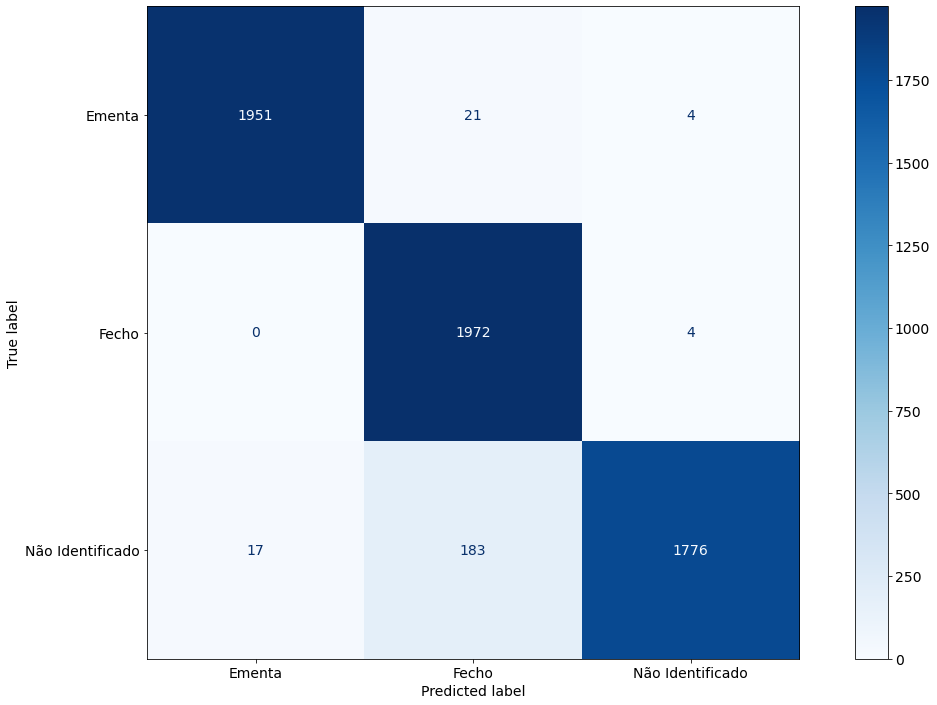

In [17]:
clf = Classificador('LinearSVC-1xR-CV', estimadorSVC_CV)
clf.treinar_com_cv(dados, cv=5)
clf.plotar_matriz_confusao(dados)

## Persistindo o modelo treinado

In [18]:
pm = PersistenciaModelo('ADE')
pm.salvar_modelo(estimadorSVC_CV)

17:38:49 - Salvando modelo treinado para o tipo ADE...
17:38:49 - Modelo salvo em ./modelos/classificador-segmentos-ade.mdl.


In [19]:
df_seg2021 = pd.read_csv('./dados/extracao-segmentos-atos-2021.csv', delimiter='|', 
                        names=['id_ato', 'data_pub', 'tipo_ato', 'id_seg', 'tipo_seg', 'txt_seg'], 
                        quotechar="'")

In [21]:
def classificar_seg(seg):
    return estimadorSVC_CV.predict(seg)